In [177]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

1. Чтение датасета об информации о раке груди. Необходимо по независимым признакам спрогнозировать есть рак или нет

In [178]:
from sklearn import datasets
data = datasets.load_breast_cancer() 
X = pd.DataFrame(data["data"], columns=data["feature_names"])
y = data["target"]

In [179]:
print(X[:5])

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

In [180]:
data["feature_names"]
y = pd.DataFrame(data["target"], columns=["target"])
print(y)

     target
0         0
1         0
2         0
3         0
4         0
..      ...
564       0
565       0
566       0
567       0
568       1

[569 rows x 1 columns]


 2.  Разведочный анализ данных:

In [181]:
# a) Сколько строк в датафрейме, сколько столбцов

print("В таблице {0} строк и {1} столбцов.".format(len(X), len(X.columns)))

В таблице 569 строк и 30 столбцов.


In [182]:
#  б)Сколько места занимает датафрейм в оперативной памяти

memory = X.memory_usage().sum()
print("Data занимает объем памяти {0} КБ.".format(round(memory/1000,1)))

Data занимает объем памяти 136.7 КБ.


In [183]:
# c) Для каждой интервальной переменной подсчитать следующее - мин, медиана, среднее, макс и персентили 25, 75

def min_data(data):
    return  data.min()
def median(data):
    return  data.median()
def mean(data):
    return  round(data.mean(), 2)
def max_data(data):
    return  data.max()
def quantile_25(data):
    return  data.quantile(0.25)
def quantile_75(data):
    return  data.quantile(0.75)


func = [min_data, median, mean, max_data, quantile_25, quantile_75]

In [184]:
statistic_data = X.agg(func)
print(statistic_data)

             mean radius  mean texture  mean perimeter  mean area  \
min_data           6.981          9.71           43.79     143.50   
median            13.370         18.84           86.24     551.10   
mean              14.130         19.29           91.97     654.89   
max_data          28.110         39.28          188.50    2501.00   
quantile_25       11.700         16.17           75.17     420.30   
quantile_75       15.780         21.80          104.10     782.70   

             mean smoothness  mean compactness  mean concavity  \
min_data             0.05263           0.01938         0.00000   
median               0.09587           0.09263         0.06154   
mean                 0.10000           0.10000         0.09000   
max_data             0.16340           0.34540         0.42680   
quantile_25          0.08637           0.06492         0.02956   
quantile_75          0.10530           0.13040         0.13070   

             mean concave points  mean symmetry  mean

Для каждой категориальной переменной рассчитать моду и
сколько раз мода встречается в данных

In [185]:
counts_dtype = X.dtypes.value_counts()
print("В таблице {0} столбца с разными типами: \n{1}.".format(len(counts_dtype), counts_dtype))
print("В данных нет категориальных переменных, {0} интервальных переменных".format(counts_dtype[0]))

В таблице 1 столбца с разными типами: 
float64    30
Name: count, dtype: int64.
В данных нет категориальных переменных, 30 интервальных переменных


array([[<Axes: title={'center': 'target'}>]], dtype=object)

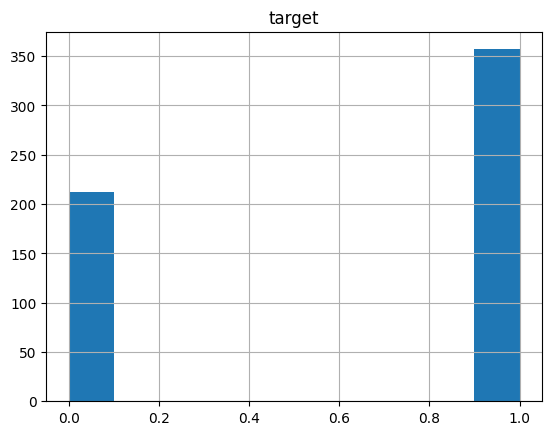

In [186]:
y.hist()

3. Подготовка датасета к построению моделей ML

In [187]:
# a. Провести анализ и обработку пропусков (либо заменить, либо удалить)

print(X.isnull().sum())
print("\nВ данных нет пропусков")

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

В данных нет пропусков


a. Провести анализ и обработку пропусков (либо заменить, либо удалить)
b. Провести анализ и обработку выбросов (либо заменить, либо удалить)
c. Провести анализ и обработку категориальных переменных (сколько таких переменных, закодируйте категориальные переменные одним из методов ( one hot encoding, mean target, frequence encoding)
d. Разделить датасет на трейн и тест

In [188]:
# b. Провести анализ и обработку выбросов (либо заменить, либо удалить)

def show_boxplot(data, columns):
    plt.figure(figsize=(20,10))
    
    for i,col in enumerate(columns):
        plt.subplot(5,6,i + 1)
        sns.boxplot(y=col, data=data)
    plt.tight_layout()
    plt.show()

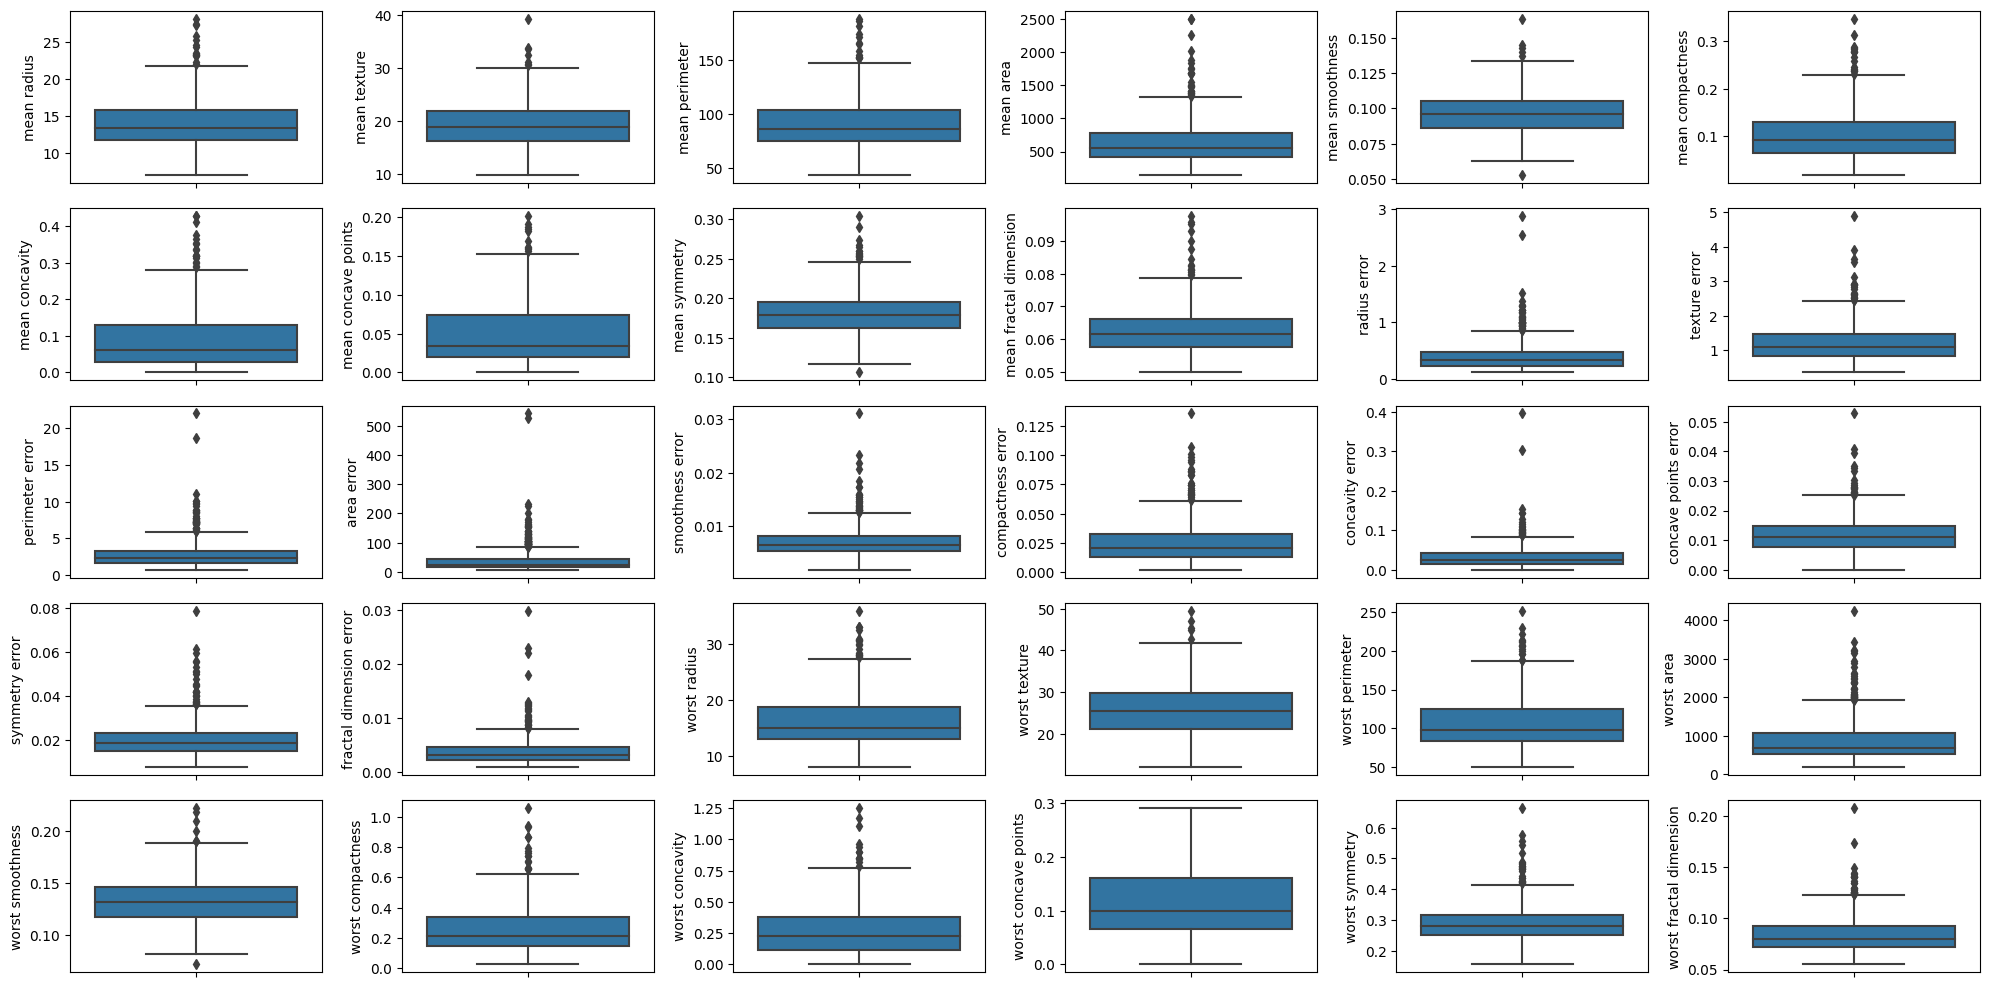

In [189]:
show_boxplot(X, X.columns)

Удалиение выбросов интерквартильным методом

In [190]:
def remove_value(data, y):
    for col in data.columns:
        print(col)
        quantile_25 = data[col].quantile(0.25)
        quantile_75 = data[col].quantile(0.75)
        iqr = quantile_75 - quantile_25
        min_value = quantile_25 - (2 * iqr)
        max_value = quantile_75 + (2 * iqr)
        print(round(min_value,2), round(max_value, 2))
        index_to_drop = data[(data[col] < min_value) | (data[col] > max_value)].index
        print(len(index_to_drop))
        data = data.drop(index_to_drop)
        y = y.drop(index_to_drop)
    return data, y

In [191]:
X, y = remove_value(X, y)

mean radius
3.54 23.94
7
mean texture
4.96 32.97
3
mean perimeter
18.94 159.12
0
mean area
-265.25 1446.0
10
mean smoothness
0.05 0.14
2
mean compactness
-0.07 0.26
5
mean concavity
-0.15 0.29
5
mean concave points
-0.07 0.16
0
mean symmetry
0.1 0.26
3
mean fractal dimension
0.04 0.08
6
radius error
-0.19 0.86
18
texture error
-0.41 2.67
9
perimeter error
-1.3 5.85
4
area error
-20.96 74.94
31
smoothness error
-0.0 0.01
12
compactness error
-0.02 0.06
8
concavity error
-0.03 0.07
4
concave points error
-0.0 0.02
1
symmetry error
0.0 0.04
8
fractal dimension error
-0.0 0.01
10
worst radius
5.95 23.6
12
worst texture
3.69 45.76
0
worst perimeter
33.68 158.96
1
worst area
-112.9 1452.6
10
worst smoothness
0.06 0.2
2
worst compactness
-0.15 0.54
7
worst concavity
-0.3 0.67
2
worst concave points
-0.06 0.24
1
worst symmetry
0.13 0.43
4
worst fractal dimension
0.04 0.12
6


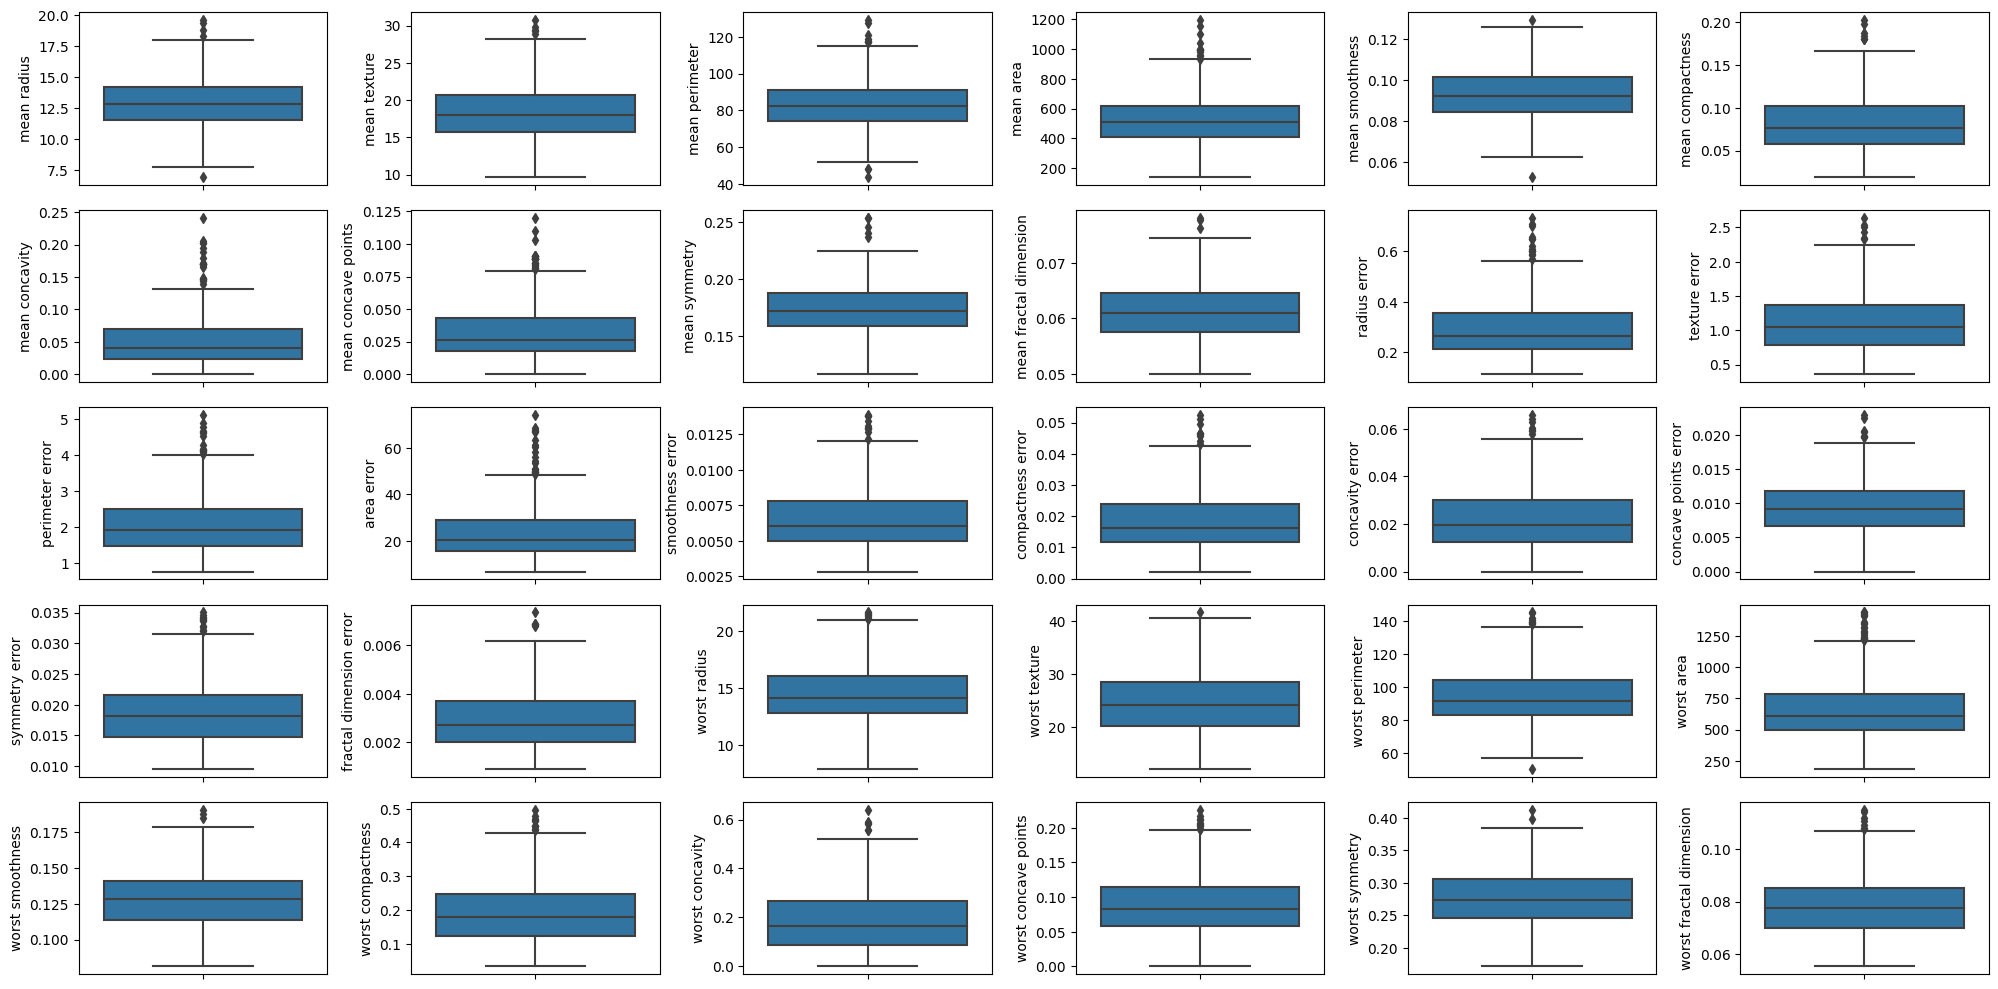

In [192]:
show_boxplot(X, X.columns)

In [193]:
x_train, x_test, y_train, y_test = train_test_split(X, list(y['target']), test_size=.2)
print(len(x_train),len(x_test),len(y_train),len(y_test))

302 76 302 76


In [194]:
sc = StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

__KNN__

In [195]:
knn_model = KNeighborsClassifier()

knn_model.fit(x_train, y_train)

KNeighborsClassifier()

__Logistic regression__

In [196]:
LogisticReg_model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

LogisticReg_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=12345)

__SVM__

In [197]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

In [198]:
param_grid = {'C': [0.01, 0.1, 0.4, 0.5, 0.7, 0.8, 0.9, 1, 2, 3, 10, 100],
              }

# Создаем модель логистической регрессии
# svm_model = SVC(kernel='linear', C=0.0)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(x_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель логистической регрессии с лучшим значением C
best_svm_model = SVC(kernel='linear', **grid_search.best_params_)
best_svm_model.fit(x_train, y_train)


Лучшее значение параметра: {'C': 0.4}


SVC(C=0.4, kernel='linear')

In [199]:
def print_score(model):
    y_pred = model.predict(x_test)
    print(f'Model {model.__class__.__name__} \n accuracy {accuracy_score(y_test, y_pred):0.4f}; \n f1 = {f1_score(y_test, y_pred):0.4f}; \n percison {precision_score(y_test, y_pred):0.4f}; \n recall {recall_score(y_test, y_pred):0.4f}')
    print(f'confusion matrix \n {confusion_matrix(y_test, y_pred)}')
    print()
    print('---------------')

In [200]:
models = [knn_model, LogisticReg_model, lin_svm_model, svm_model, best_svm_model]

for mod in models:
    print_score(mod)

Model KNeighborsClassifier 
 accuracy 0.9474; 
 f1 = 0.9692; 
 percison 0.9692; 
 recall 0.9692
confusion matrix 
 [[ 9  2]
 [ 2 63]]

---------------
Model LogisticRegression 
 accuracy 0.9868; 
 f1 = 0.9924; 
 percison 0.9848; 
 recall 1.0000
confusion matrix 
 [[10  1]
 [ 0 65]]

---------------
Model LinearSVC 
 accuracy 0.8289; 
 f1 = 0.8889; 
 percison 1.0000; 
 recall 0.8000
confusion matrix 
 [[11  0]
 [13 52]]

---------------
Model SVC 
 accuracy 0.9605; 
 f1 = 0.9771; 
 percison 0.9697; 
 recall 0.9846
confusion matrix 
 [[ 9  2]
 [ 1 64]]

---------------
Model SVC 
 accuracy 0.9868; 
 f1 = 0.9924; 
 percison 0.9848; 
 recall 1.0000
confusion matrix 
 [[10  1]
 [ 0 65]]

---------------


Лучшими предсказательными способностями обладают алгоритмы Логистической регресии и метод опорных векторов С =0.4

Улучшить модель можно, если добавить нелинейность в SVM (kernel':['poly', 'rbf', 'sigmoid',])